## Detection of Broken MCMC Samplers - MH/1D Gaussian
In this notebook, we deliberately break a standard Metropolis Hastings sampler by causing it to incorrectly accept proposals with a certain probability. The sampler is used on the 1D Gaussian distribution.

## Dependencies
This notebook uses hildensia's implementation of the ''Bayesian Online Changepoint Detection'' algorithm by Ryan Adams and David MacKay, available at the following link

https://github.com/hildensia/bayesian_changepoint_detection

In [1]:
from functools import partial
import random
import matplotlib.pyplot as plt
import numpy as np
import pints
import pints.toy
import pints.plot
import bayesian_changepoint_detection.online_changepoint_detection as oncd

In [2]:
class BrokenMH(pints.MetropolisRandomWalkMCMC):
    """Broken version of Metropolis Hastings.

    At each MH step, with probability given by error_freq, it will always
    accept the proposal.
    """
    def __init__(self, x0, sigma0=None):
        super().__init__(x0, sigma0)
        self.error_freq = 0.0

    def set_error_freq(self, error_freq):
        self.error_freq = error_freq

    def tell(self, fx):
        if self.error_freq == 0.0 or random.random() > self.error_freq:
            # Run MH step correctly
            return super().tell(fx)
        else:
            # Always accept it even if it is bad
            self._acceptance = ((self._iterations * self._acceptance + 1) /
                                (self._iterations + 1))
            self._iterations += 1
            self._current = self._proposed
            self._current_log_pdf = fx
            self._proposed = None
            return self._current

In [3]:
class NormalDist(pints.toy.GaussianLogPDF):
    """Same as Pints, except it doesn't complain about KLD for 1d distribution.

    # todo: check if there is a problem in pints
    """
    def kl_divergence(self, samples):
        """
        Calculates the Kullback-Leibler divergence between a given list of
        samples and the distribution underlying this LogPDF.

        The returned value is (near) zero for perfect sampling, and then
        increases as the error gets larger.

        See: https://en.wikipedia.org/wiki/Kullback-Leibler_divergence
        """
        m0 = np.mean(samples, axis=0)
        m1 = self._mean
        s0 = np.cov(samples.T)
        s1 = self._sigma
        cov_inv = np.linalg.inv(s1)

        if s0.ndim < 2:
            s0 = np.array([[s0]])

        dkl1 = np.trace(cov_inv.dot(s0))
        dkl2 = np.dot((m1 - m0).T, cov_inv).dot(m1 - m0)
        dkl3 = np.log(np.linalg.det(s1) / np.linalg.det(s0))
        return 0.5 * (dkl1 + dkl2 + dkl3 - self._n_parameters)

In [4]:
def get_klds(num_runs, start_breaking, error_freq):
    """Run MCMC multiple times, break at some point, and get the KL divs.
    
    It uses the BrokenMH sampler and the 1D Gaussian distribution.

    Parameters
    ----------
    num_runs : int
        Total number of runs
    start_breaking : int
        Which run to break the MCMC algorithm
    error_freq : float
        Error probability per MH step once the algorithm is broken

    Returns
    -------
    list
        List of kl divergences from samples to posterior for each run
    """
    posterior = NormalDist(np.array([1.0]), np.array([0.1**2]))
    x0 = [np.array([1.0])]

    klds = []
    for run in range(num_runs):
        mcmc = pints.MCMCController(posterior, 1, x0, method=BrokenMH)
        mcmc.set_max_iterations(1000)
        if run >= start_breaking:
            for s in mcmc.samplers():
                s.set_error_freq(error_freq)

        mcmc.set_log_to_screen(False)
        chains = mcmc.run()
        kld = posterior.kl_divergence(chains[0])
        klds.append(kld)

    return klds

In [5]:
def run_changepoint(data):
    """Run changepoint detection using the library.
    """
    ## Set hyperparameters
    # timescale of hazard function
    lam = 250

    # T distribution parameters
    # df=2*self.alpha,
    # loc=self.mu,
    # scale=np.sqrt(self.beta * (self.kappa+1) / (self.alpha * self.kappa))
    alpha = 0.1
    beta = 0.01
    kappa = 1.0
    mu = 0.0

    R, maxes = oncd.online_changepoint_detection(
        data,
        partial(oncd.constant_hazard, lam),
        oncd.StudentT(alpha, beta, kappa, mu))

    return R

We run the following experiment to test broken MCMC sampling and changepoint detection.

The MCMC sampler is run 60 times. From the 30th run onwards, the sampler is deliberately broken by insisting that at each accept/reject step, the proposal will be automatically accepted with probability 0.15. 

Next, we attempt to detect any changepoints in the series of KL divergences obtained.

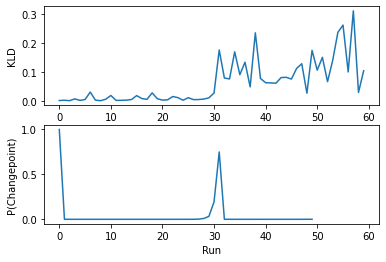

In [6]:
random.seed(1000)
np.random.seed(1000)

klds = get_klds(60, 30, 0.15)
R = run_changepoint(klds)

runs = np.arange(len(klds))

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(runs, klds)
ax.set_ylabel('KLD')

ax = fig.add_subplot(2, 1, 2, sharex=ax)
window_size = 10  # How many time points to get before evaluating
                  # probability
ax.plot(runs[:-window_size], R[window_size, window_size:-1])

ax.set_xlabel('Run')
ax.set_ylabel('P(Changepoint)')

plt.show()